# Exercise 02
## Hungarian Matching and ReID


In this exercise, we investigate appearance-based tracking by training a ReID network that we apply to the [MOT16](https://motchallenge.net/data/MOT16/) dataset.

Your task is the following:
- to implement Hungarian matching in the tracker.
- to train a small ReID dataset with cross-entropy and triplet-loss.
- to apply the trained ReID network on the detected MOT16 bounding boxes.

## Imports

This will setup your whole environment such that you can work with the rest of the notebook.

### General Imports

In [1]:

from pathlib import Path
import time

from tqdm.autonotebook import tqdm
import torch
from torch.utils.data import DataLoader

<ipython-input-1-0c174e61d3bd>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.cuda.is_available()

True

## Set up directory paths and (optionally) mount them in Google Colab
If you work with google colab set the `USING_COLAB` variable to `True` in the following cell to mount your gdrive.

In [3]:
USING_COLAB = True
USE_CPU = False
# Use the following lines if you want to use Google Colab
# We presume you created a folder "cv3dst" within your main drive folder and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Ensure you define the correct exercise folder (e.g exercise_03).

if USING_COLAB:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/masters/CVIII/task2/cv3dst/exercise_02'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    # install required packages
    !pip install -r ../requirements.txt
    root_dir = Path(gdrive_path).parent
    # root_dir = Path('/content/gdrive/MyDrive/masters/CVIII/task2').parent
    print("root_dir",root_dir)
else:
    root_dir = Path('./cv3dst/')
dataset_dir = root_dir.joinpath("datasets")
output_dir = root_dir.joinpath('exercise_02', 'models')
output_dir.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() and not USE_CPU else torch.device('cpu')

Mounted at /content/gdrive
['exercise_code', 'hungarian_tracking.ipynb', 'models']
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.8 MB/s eta 0:00:00
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628964 sha256=3bdf8a9fef30f32d1a1c3f8d6406e42a260e6fbb498eef16b918ef0a926e08e1
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: ipyleaflet
  

### Exercise Specific Imports

In [4]:
from exercise_code import (
    MOT16Sequences,
    ImageDataManager,
)

from exercise_code import (
    FRCNN_FPN,
    Min_TrackerIoU,
    Hungarian_TrackerIoU,
    Hungarian_TrackerIoUReID,
    build_model,
    train_classifier,
    train_metric_mapping,
)

from exercise_code.test import (
    test_hungarian_tracking_iou,
    test_distance_metric,
    test_hard_mining,
    test_hungarian_tracking_ioureid,
    )

from exercise_code.visualization import sequence, plot_sequence

%load_ext autoreload
%autoreload 2
%matplotlib inline

You experimented with the object detectors already in the last exercise. This time, we will use the SOTA object detector trained on the MOT challenge training set.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) [1] with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information, check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

[1] [Ren et al. Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks, NeurIPS 2015](https://arxiv.org/abs/1506.01497)


### Configuration

In [5]:
# object detector
obj_detect_model_file = output_dir.joinpath('faster_rcnn_fpn.model')
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=0.3)
obj_detect_state_dict = torch.load(obj_detect_model_file, map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

# Multi-object tracking

## Dataset
The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challenging scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class allows one to load single sequences, e.g., `seq_name = 'MOT16-02'`, or the entire train/test set, e.g., `seq_name = 'MOT16-train'`.

In [6]:
seq_name = 'MOT16-02'
sequences = MOT16Sequences(seq_name, dataset_dir.joinpath('MOT16'), load_seg=True)

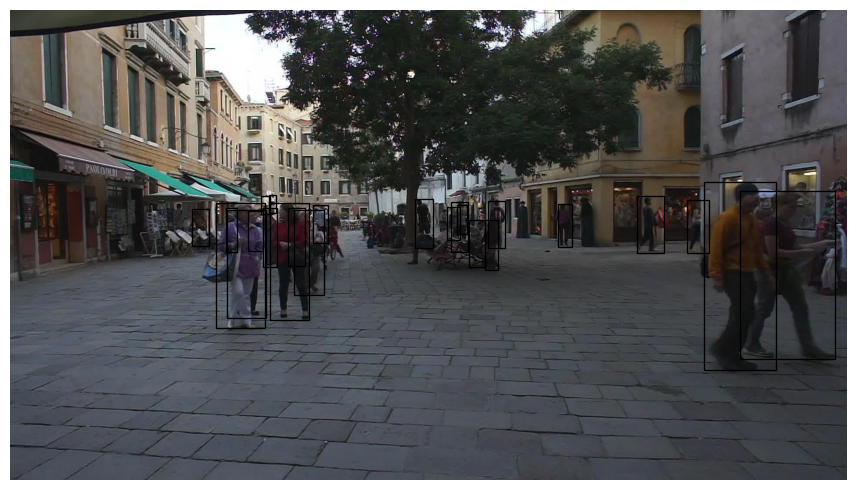

In [7]:
# visualize the frame_idx of sequence seq_idx
sequence(sequences, seq_idx=0, frame_idx=30)

## Exercise Part I - Hungarian IoU Tracker

We provided you a simple baseline tracker (<code>Min_TrackerIoU</code>) in <a href="../exercise_02/exercise_code/model/hungarian_tracker.py"><code>exercise_code/model/hungarian_tracker.py</code></a>. It predicts object detections for each frame and generates tracks by assigning current detections to previous detections via the maximum Intersection over Union.

The tracker `Min_TrackerIoU` will build a cost matrix as follows:
Given $n$ tracks $t$ and $m$ detected boxes $b$, the result will be a matrix

$D \in [0,1]^{n\times m}, \quad d_{ij}=\begin{cases} 1 - \operatorname{IoU}(t_i, b_j) \quad &\text{for} \operatorname{IoU}(t_i, b_j) >= 0.5 \\ NaN  &\text{otherwise} \end{cases}$

Then, the `Min_TrackerIoU` extends each track with the box with minimum distance/maximum overlap.
All predicted boxes that don't overlap enough with the tracks (i.e., $\operatorname{IoU} < 0.5$) start new tracks.

This Tracker has several issues. Can you spot them?

<div class="alert alert-info">
    <h3>Task: Hungarian Tracking</h3>
    <p> Go to
    <a href="../exercise_02/exercise_code/model/hungarian_tracker.py"><code>exercise_code/model/hungarian_tracker.py</code></a> again. In the <code>Hungarian_TrackerIoU</code> class complete the <code>data_association</code> method. The new tracker should ensure unique matching. Therefore, the assignment is done by the function `linear_assignment` from the `scipy.optimize` package, which is described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html). It solves the optimal transport problem for the discrete finite case.
    Your task is to add the matched boxes to the stored tracks.
    </p>
</div>

Here, you can switch between the old tracker and the new tracker.

In [8]:
old_tracker = True
if old_tracker:
    # Old Tracker
    tracker = Min_TrackerIoU(obj_detect)
else:
    # New tracker
    tracker = Hungarian_TrackerIoU(obj_detect)

We evaluate the tracker by computing the MOT metrics. To do so, we first run the tracker on a predefined dataset and store the resulting tracks for later evaluation.

In [9]:
def run_tracker(sequences, tracker, device):
    time_total = 0
    results_seq = {}
    for seq_idx, seq in enumerate(sequences):
        tracker.reset()
        now = time.time()

        print(f"Tracking {seq_idx}: {seq}")

        # Create a dataloader for a sequence
        data_loader = DataLoader(seq, batch_size=1, shuffle=False)

        # Get the resulting tracks for the sequence
        for data in tqdm(data_loader):
            frame = data['img'].to(device)
            tracker.step(frame)
        results = tracker.get_results()
        results_seq[str(seq)] = results

        time_total += time.time() - now

        print(f"Tracks found: {len(results)}")
        print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    print(f"Runtime for all sequences: {time_total:.1f} s.")
    return results_seq

seq_name = 'MOT16-reid'
sequences = MOT16Sequences(seq_name, dataset_dir.joinpath("MOT16"))
results_seq = run_tracker(sequences, tracker, device)

Tracking 0: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 357
Runtime for MOT16-02: 581.1 s.
Tracking 1: MOT16-05


  0%|          | 0/837 [00:00<?, ?it/s]

Tracks found: 449
Runtime for MOT16-05: 749.8 s.
Tracking 2: MOT16-09


  0%|          | 0/525 [00:00<?, ?it/s]

Tracks found: 95
Runtime for MOT16-09: 501.7 s.
Tracking 3: MOT16-11


  0%|          | 0/900 [00:00<?, ?it/s]

Tracks found: 289
Runtime for MOT16-11: 891.5 s.
Runtime for all sequences: 2724.1 s.


Save the results to a file that the evaluation function can read.

In [41]:
torch.save(results_seq, "exercise_code/test/"+tracker.name+".pth")


<div class="alert alert-danger">
    <h3>Test: Hungarian Tracking</h3>
    <p>
    As a point of reference, we provide the results you should expect from the <code>Hungarian_TrackerIoU</code>. We will also compare the MOTA values produced by your tracker to the implementation reference. As always, the test does <b>not</b> guarantee correct implementation. Please look at the summary of evaluation metrics and their definition below, as it will help you interpret the results.</p>
</div>


### MOT Evaluation Metrics

To evaluate our tracker, we must match predicted and ground truth detections.

The Hungarian algorithm determines a bijective mapping between ground truth detections and track IDs in each frame to compute the subsequent metrics.
- FP: False positives are predicted detections that are not in the ground truth detections
- FN: False negatives are ground truth detections that are not in the predicted detections
- P_pred = FP+TP: All predicted detections
- P = FN+TP: All ground truth detections
- Prcn = TP/P $\uparrow$: The ratio of TP overall ground-truth detections
- Rcll = TP/P_pred $\uparrow$: The ratio of TP overall predicted detections
- IDsw $\downarrow$: The number of identity switches is the number of different track IDs assigned to the detections of one ground truth track. Therefore, a smaller IDsw value is better.
- MOTA $\uparrow$: The number of the above errors divided by the number of ground truth detections should be small. Therefore, a higher MOTA value is better. $$\operatorname{MOTA} =  1- \frac{\sum_t FN_t + FP_t + IDSW_t}{\sum_t P_t}$$ THE MOTA can not be bigger than one, but it can also be negative.

The Hungarian algorithm determines a bijective mapping between unique person IDs and track IDs for each sequence to compute the subsequent metrics.

- IDFN/IDTP/IDFP: Same as above, but we check if the unique person IDs are correct (after bijective mapping is fixed).
- IDP = IDTP/(IDFP+IDTP) $\uparrow$: The ID precision
- IDR = IDTP/(IDFN+IDTP)$\uparrow$: The ID recall
- IDF1 $\uparrow$: The ratio of correctly identified detections over the average number of ground-truth and computed detections

Some additional metrics are:
- ML: Mostly lost tracks
- MT: Mostly tracked tracks
- PT: Partly tracked
- GT: Number of tracks

You can find a more detailed description of the measures in the paper https://arxiv.org/pdf/2009.07736v2.pdf and the repository https://github.com/cheind/py-motmetrics.
You can also look at the performance of the state-of-the-art object trackers here https://motchallenge.net/results/MOT16/.

In [43]:
test_hungarian_tracking_iou()

              IDF1       IDP       IDR      Rcll      Prcn  GT  MT  PT  ML   FP    FN  IDs   FM      MOTA      MOTP   IDt    IDa  IDm
MOT16-02  0.459425  0.652566  0.354502  0.490447  0.902814  62  12  35  15  981  9468  121  122  0.431139  0.098999  21.0  103.0  4.0
MOT16-02  0.409387  0.587909  0.314030  0.517034  0.967960  62  12  36  14  318  8974  191  194  0.489640  0.088503   NaN    NaN  NaN
Hungarian_TrackerIoU does not seem to be correct for MOT16-02 based on the metrics: mota idf1.
Some tests failed for method (). Tests passed: 0/1
Score: 0/100


0

You can also debug your code qualitatively by visualizing the tracking results using the subsequent plot function:

In [17]:
plot_sequence(results_seq['MOT16-02'],
              [s for s in sequences if str(s) == 'MOT16-02'][0],
              first_n_frames=10)

Output hidden; open in https://colab.research.google.com to view.

# Exercise Part II - ReID Evaluation

For this and the next part of the exercise, you will train a simple ReID network on the Market data with two different strategies. But first, we focus on implementing the evaluation during training, which will help us to observe the training process.


<div class="alert alert-info">
    <h3>Task: Distance Metrics</h3>
    We ignore the last classification layer(if present) and work on the extracted features during evaluation. This feature vector should be very similar for the same instance and not similar for different instances.
    In the following, you have to implement two distance measurements.
    <p> Go to <code>exercise_code/model/distance_metrics.py</code> and complete the functions for calculating.
    <ul>
        <li><code>euclidean_squared_distance</code></li>
        <li><code>cosine_distance</code></li>
    </ul>
    Then, choose the metric function you want to use for evaluation in one of the cells below.
    You are not allowed to change the interface of the function. Please have a look at the [Pytorch documentation](https://pytorch.org/docs/stable/index.html).
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: Distance Metrics</h3>
    <p> Run the following cell to execute the test case for evaluating the distance computation.
     </p>
</div>

In [18]:
_ = test_distance_metric()

Congratulations: The euclidean distance was computed correctly.
Congratulations: The cosine distance was computed correctly.
All tests of DistanceMetricsTest passed. Tests passed: 2/2
Score: 100/100


With the implemented distance measure, we can now compute the distance between features in the evaluation <code>exercise_code/model/evaluate_reid.py</code>. You need to define the metric function you want to use for evaluation. We extract features for the query and gallery sets and then build a distance matrix based on your implemented distance measure.

# Exercise Part III - Training with Classification Loss.

For $n$ different people, we will have $n$ different classes. The model's output is the normalized distribution over classes, and we train the network with a cross-entropy loss, which aligns the probability distribution along the $n$ classes
$$ \mathcal{L} = - \sum_{x=1}^n \log p(x) q(x),$$
i.e., the network needs to classify each image to its labelled class.

We compute a loss for each image sample individually to train the classifier. The ground truth distribution we align the output with is the class label (stored as a distribution over classes in the variable pids) provided in the market dataset.

 ### Architecture
 This exercise will use a ResNet34/ResNet50 neural network that extracts features from an input image.
 Let's create a resnet34 model and move it to the GPU.
There is a drawback to using a classification loss for training. Can you spot it already by looking at the initialization code?

In [20]:
datamanager = ImageDataManager(root=str(dataset_dir),
                               height=256,
                               width=128,
                               batch_size_train=32,
                               workers=2,
                               transforms=['random_flip', 'random_crop'],
                               train_sampler='RandomIdentitySampler')


Building train transforms ...
+ resize to 256x128
+ random flip
+ random crop (enlarge to 288x144 and crop 256x128)
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   601 |     1640 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded Market1501
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   601 |     1640 |         6
  query    |   750 |     3368 |         6
  gal

In [21]:
model = build_model('resnet34', datamanager.num_train_pids, loss='softmax', pretrained=True)
model = model.to(device)

trainable_params = model.parameters()
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 67.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Answer to the question: We have to adjust the network architecture to the classes provided in the dataset. Therefore, we created the DataManager for the Market dataset already.

### Training

In [22]:
train_loader = datamanager.train_loader
test_loader = datamanager.test_loader

For training the network, we also need to choose an optimizer and learning rate scheduler:

In [23]:
optimizer = torch.optim.Adam(trainable_params, lr=0.0003, # <--- Feel free to play around with the lr parameter.
                             weight_decay=5e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

Finally, we can implement the training logic. For this exercise we have done this already. Please look at the classifier training in <code>exercise_code/model/train_reid.py</code>.

In [ ]:
# model = train_classifier(model, optimizer, scheduler, train_loader, test_loader, device)
model = train_classifier(model, optimizer, scheduler, train_loader, test_loader, device)

In [44]:
torch.save(model, output_dir.joinpath('classifier-reid_model.pth'))

# Exercise Part III - Triplet loss and hard negative mining.

Using a classifier for a new dataset with different instances and numbers of classes is impractical. Thus, when using the network above and its predicted class distribution as a distance measure in a tracker, we need to finetune it to the new number of classes in the tracking data.
Another strategy is to assume that the features in the last layer of the classifier are more similar for the same instance than for different instances. We have used this in the evaluation already. However, we never trained the model to map the images to features with these metric properties.
In this exercise, instead of using the classification loss, we discard the last layer of the model and directly compute the loss using the features and pairs/triplets of images.

We use the triplet loss, which takes three images and enforces matching samples (positive pair) to be mapped to closer features than non-matching samples (negative pair).
$$\mathcal{L} = \max(\{0, m+d(A,P)-d(N,P)\})$$
For computing the distance between pairs of features, we will reuse the distance functions you already implemented.

<div class="alert alert-info">
    <h3>Task: Triplet Loss and Hard Negative Mining</h3>
    <p> We divided this task into different subtasks. Go to <code>exercise_code/model/hard_mining.py</code> and read through the description of every subtask.
    First, you have to compute the distance matrix based on the similarity of features. Second, you must find the hardest-to-distinguish negative pairs and the hardest-to-match positive pairs in the training batch and store the results in a list. Third, convert it to the correct format, readable by the pytorch ranking loss.
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: Triplet Loss and Hard Negative Mining</h3>
    <p> Run the following cell to execute the test case for triplet loss and hard negative/positive mining.</p>
</div>

In [32]:
_ = test_hard_mining()

Congratulations: HardBatchMining returns the correct shape.
Congratulations: HardBatchMining seems to be correct.
Method compute_distance_pairs() correctly implemented. Tests passed: 2/2
Score: 100/100


### Architecture
We build a model with a similar architecture as the classifier. We even keep the softmax layer to use the classification loss on top of the triplet loss for training.

In [33]:
model = build_model('resnet34', datamanager.num_train_pids, loss='triplet', pretrained=True)
model = model.to(device)

trainable_params = model.parameters()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training



In [34]:
optimizer = torch.optim.Adam(trainable_params, lr=0.0003,
                             weight_decay=5e-4, amsgrad=True)# <--- Feel free to play around with the lr parameter.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

Finally, we can implement the training logic again. For this exercise, you provided the Triplet Loss, which the trainer uses as part of the Combined Loss. Also, your implementations of the distance functions are part of the Triplet Loss implementation.
We again provide the training script already in <code>exercise_code/model/train_classifier.py</code>. You can play around with different weighting, which balances classification and metric learning.

In [ ]:
model = train_metric_mapping(model, optimizer, scheduler, train_loader, test_loader, device)

In [45]:
torch.save(model, output_dir.joinpath('final-reid_model.pth'))

# Exercise Part IV - Putting everything together

In this part, you will combine the ReID model with the tracker to compute appearance-based matching. You should be able to reuse most of the code of the already implemented Hungarian tracker.

<div class="alert alert-info">
    <h3>Task: Putting Everything Together</h3>
    <p> Go to <code>exercise_code/model/hungarian_tracker.py</code>. In the <code>Hungarian_TrackerIoUReID</code> class complete the <code>data_association</code> method.
    </p>
</div>

In [ ]:
reid = torch.load(output_dir.joinpath( 'final-reid_model.pth'))

In [ ]:
tracker = Hungarian_TrackerIoUReID(obj_detect, reid)

Now, let's rerun the tracker and produce some results.

In [ ]:
seq_name = 'MOT16-reid'
sequences = MOT16Sequences(seq_name, dataset_dir.joinpath("MOT16"))
results_seq = run_tracker(sequences, tracker, device)

In [ ]:
torch.save(results_seq, "exercise_code/test/"+tracker.name+".pth")


<div class="alert alert-danger">
    <h3>Test: Hungarian Tracking with IoU and ReID</h3>
    <p>
    As a point of reference, we provide the results you should expect from the <code>Hungarian_TrackerIoUReID</code>. We will also compare the MOTA values produced by your tracker to the implementation reference. As always, the test does <b>not</b> guarantee correct implementation. Please look at the summary of evaluation metrics and their definition in Section I of this exercise, as it will help you interpret the results.</p>
</div>

In [38]:
test_hungarian_tracking_ioureid()

              IDF1       IDP       IDR      Rcll      Prcn  GT  MT  PT  ML   FP    FN  IDs   FM      MOTA      MOTP   IDt    IDa  IDm
MOT16-02  0.459425  0.652566  0.354502  0.490447  0.902814  62  12  35  15  981  9468  121  122  0.431139  0.098999  21.0  103.0  4.0
MOT16-02  0.409387  0.587909  0.314030  0.517034  0.967960  62  12  36  14  318  8974  192  194  0.489586  0.088503   NaN    NaN  NaN
Congratulations: Hungarian_TrackerIoUReID seems to be correct for sequence MOT16-02 based on the metrics: mota idf1.
Some tests failed for method (). Tests passed: 0/1
Score: 0/100


0

# Exercise submission

Make sure to run the tracker for <code>seq_name = 'MOT16-reid'</code> before submission.

In [40]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise02')

relevant folders: ['exercise_code', 'models']
notebooks files: ['hungarian_tracking.ipynb']
Adding folder exercise_code
Adding folder models
faster_rcnn_fpn.model
classifier-reid_model.pth
final-reid_model.pth
Adding notebook hungarian_tracking.ipynb
Zipping successful! Zip is stored under: /content/gdrive/MyDrive/masters/CVIII/task2/cv3dst/output/exercise02.zip


## Optional next steps

Now that you have implemented the above exercise. You can start thinking about extending it further. Often, appearance-based features are not primarily used for frame-to-frame matching but for track recovery. In our current setting, we lose a track when a detection is missing (due to occlusions or bad detection results). ReID features could help recover such (inactive) tracks a few frames later.